# 住宅価格の予測

Week3で使用したアイオワ州エイムズ市の住宅価格データセットを使い、回帰問題を解く練習をします。


79種類の特徴量（説明変数）を活用し、住宅価格の数値を推測する問題が設定できます。こういった連続値のものを推測する問題を回帰問題と呼びます。


[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv)



### Kaggle Competition Description

Competition Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting

### 今回使う手法の一覧
scikit-laernを使い以下の手法で学習と推定を行っていきます。それぞれの手法についての詳細は今の段階では扱いません。ライブラリを使えばどれも気軽に利用できることや、手法毎の結果に違いがあることを簡単に見ていきます。


- 線形回帰
- SVM
- 決定木
- ランダムフォレスト

In [29]:
#Set up environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Import sklearn ML models

#訓練データと検証データの分割
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

#線形回帰
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#SVM
from sklearn.pipeline import make_pipeline
#決定木
from sklearn.tree import DecisionTreeRegressor
#ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [3]:
pwd

'/Users/MatthewH/Desktop/Study/Data Science and Maths/Data Science and Machine Learning/Machine Learning/DIVE INTO CODE/事前予習/WEEK4/事前課題'

In [4]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### 【問題1】練習のために特徴量の選択

データセットを読み込んだ後、説明変数GrLivAreaとYearBuilt、目的変数SalePriceをそれぞれ抜き出してください。

In [5]:
df_GrLivArea = df.filter(like='GrLivArea')
df_YearBuilt = df.filter(like='YearBuilt')
df_SalePrice = df.filter(like='SalePrice')

df_practice = pd.concat([df_GrLivArea, df_YearBuilt, df_SalePrice], axis=1)
df_practice

,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000
...,...,...,...
1455,1647,1999,175000
1456,2073,1978,210000
1457,2340,1941,266500
1458,1078,1950,142125


### 【問題2】線形回帰による推定と評価

- データを簡単に分析、前処理し、線形回帰 による学習、推定、評価、可視化までの一連の流れを作成・実行してください。

評価のための指標値は回帰問題では 平均二乗誤差（Mean Squared Error, MSE） を使うことが一般的です。<br>
可視化は横軸にある特徴量、縦軸に推測した住宅価格といった方法で行えます。<br>
scatterを用いて、実際のデータと予測結果を比較できるグラフを作りましょう。

/Users/MatthewH/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


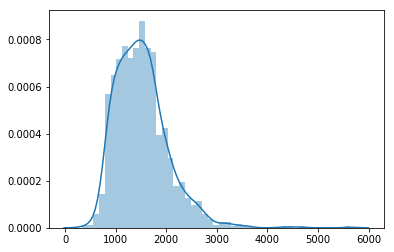

In [12]:
#データを分析

sns.distplot(df_GrLivArea)

/Users/MatthewH/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


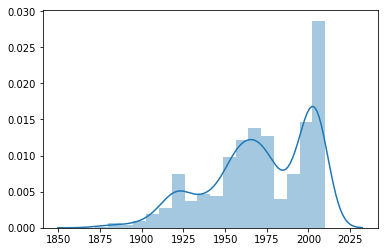

In [13]:
sns.distplot(df_YearBuilt)

/Users/MatthewH/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


AttributeError: module 'pandas' has no attribute 'skewness'

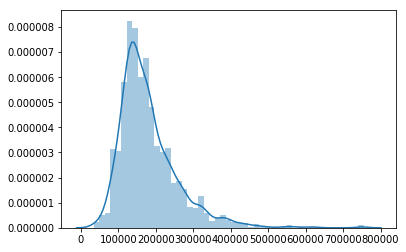

In [15]:
sns.distplot(df_SalePrice)
pd.skewness(df_SalePrice)

In [17]:
from scipy.stats import skew, kurtosis

skew(df_SalePrice), kurtosis(df_SalePrice)

(array([1.88094075]), array([6.50981201]))

In [19]:
df_practice.describe()

,GrLivArea,YearBuilt,SalePrice
count,1460.000000,1460.000000,1460.000000
mean,1515.463699,1971.267808,180921.195890
std,525.480383,30.202904,79442.502883
min,334.000000,1872.000000,34900.000000
25%,1129.500000,1954.000000,129975.000000
50%,1464.000000,1973.000000,163000.000000
75%,1776.750000,2000.000000,214000.000000
max,5642.000000,2010.000000,755000.000000


In [27]:
df_practice.corr()

,GrLivArea,YearBuilt,SalePrice
GrLivArea,1.000000,0.199010,0.708624
YearBuilt,0.199010,1.000000,0.522897
SalePrice,0.708624,0.522897,1.000000


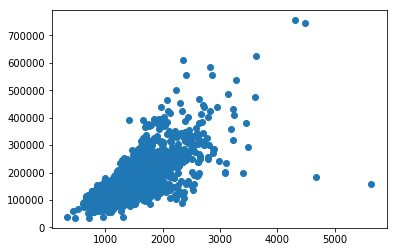

In [20]:
#Scatter 1
plt.scatter(df_GrLivArea, df_SalePrice)

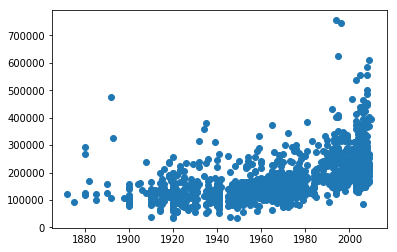

In [22]:
#Scatter 2
plt.scatter(df_YearBuilt, df_SalePrice)

### 分析結果：
- 目的変数は、歪度が正の値を示しており、少し左側に偏りを見せている。尖度もまた６.５と中央値あたりである、１８万ドル付近にデータが集中している。正規分布に近い目的変数として線形回帰のモデルを適応するのは妥当であると見れる。
- 説明変数の建築年は、正規分布の形をしておらず、標準化の対象にする
- GrLivAreaは、70%ほどと正の相関関係を示している
- YearBuiltは、19%ほどとほぼ無関係であることを示している

```概ね、0～0.3未満：ほぼ無関係、0.3～0.5未満：非常に弱い相関、0.5～0.7未満：相関がある、0.7～0.9未満：強い相関、0.9以上：非常に強い相関と言われています。```

### 前処理

- test/train split
- standardize YearBuilt

In [65]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df_practice.iloc[:, :2], df_practice.iloc[:, 2], test_size=0.25, random_state=42)


In [66]:
#transform doesn't work on series???
X_train_df = pd.DataFrame(data=X_train, columns=df_practice.columns[:2])
X_test_df = pd.DataFrame(data=X_test, columns=df_practice.columns[:2])
y_train_df = y_train.to_frame(name='SalePrice')
y_test_df = y_test.to_frame(name='SalePrice')

In [135]:
#standardize YearBuilt

scaler = StandardScaler()

#x_train needs to be fit the transformed -> x_train will have the information from the fit so just needs to be transformed
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_test

(array([[-0.0516431 ,  1.1078893 ],
        [-0.42169218,  0.09454315],
        [-0.51847425, -1.04955734],
        ...,
        [-1.26616316, -0.52653997],
        [-0.19966273, -1.73601764],
        [ 0.04513897,  1.17326647]]),
 array([[-8.79034893e-01, -2.65031290e-01],
        [ 2.06997164e+00,  7.48314862e-01],
        [-9.54942397e-01, -1.44182037e+00],
        [ 2.51986918e-01, -7.88048659e-01],
        [ 1.68488663e-01,  1.17326647e+00],
        [-1.71022206e+00,  2.91659800e-02],
        [ 8.02316322e-01, -1.04955734e+00],
        [-1.42732103e-01,  2.25297493e-01],
        [-1.71022206e+00, -3.62111911e-02],
        [-2.62286422e-01, -5.26539974e-01],
        [-1.02880664e-01, -1.40913178e+00],
        [-1.24718629e+00, -1.01588362e-01],
        [-1.20923254e+00, -1.18031169e+00],
        [ 7.18521717e-03,  1.07520072e+00],
        [ 3.01326795e-01,  9.44446375e-01],
        [-9.92896149e-01, -5.91917145e-01],
        [ 3.58257423e-01,  1.07520072e+00],
        [-7.53787511e

Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.

This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

### 線形回帰

線形回帰による:
- 学習
- 推定
- 評価 (平均二乗誤差（Mean Squared Error, MSE)
- 可視化

In [136]:
#学習
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [193]:
r1 = linear_reg.score(X_train, y_train)
r2_linear_reg = linear_reg.score(X_test, y_test)

r1, r2

(0.647270714473142, 0.9330601183262975)

In [138]:
#推定
predicted = linear_reg.predict(X_test)
predicted.shape, y_pred

((365,),
 array([ 35311.        ,  60127.86206897,  84944.72413793, 109761.5862069 ,
        134578.44827586, 159395.31034483, 184212.17241379, 209029.03448276,
        233845.89655172, 258662.75862069, 283479.62068966, 308296.48275862,
        333113.34482759, 357930.20689655, 382747.06896552, 407563.93103448,
        432380.79310345, 457197.65517241, 482014.51724138, 506831.37931034,
        531648.24137931, 556465.10344828, 581281.96551724, 606098.82758621,
        630915.68965517, 655732.55172414, 680549.4137931 , 705366.27586207,
        730183.13793103, 755000.        ]))

In [139]:
y_test.shape, y_test

((365,), 892     154500
 1105    325000
 413     115000
 522     159000
 1036    315500
          ...  
 988     195000
 243     120000
 1342    228500
 1057    248000
 1418    124000
 Name: SalePrice, Length: 365, dtype: int64)

In [195]:
#評価 (平均二乗誤差（Mean Squared Error, MSE)

MSE_linear_reg = mean_squared_error(y_test, predicted)
MSE_linear_reg

2314465092.7320137

In [141]:
#評価 (平均二乗誤差（Mean Squared Error, MSE)の確認

y_diff = y_test - predicted 
y_diff_mse = ((y_test - predicted)**2).sum() / 365
y_diff_mse

2314465092.7320137

In [145]:
#可視化
x_pred = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 30)   # range of GRLIVING
y_pred = np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), 30)  # range of YEARBUILT
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

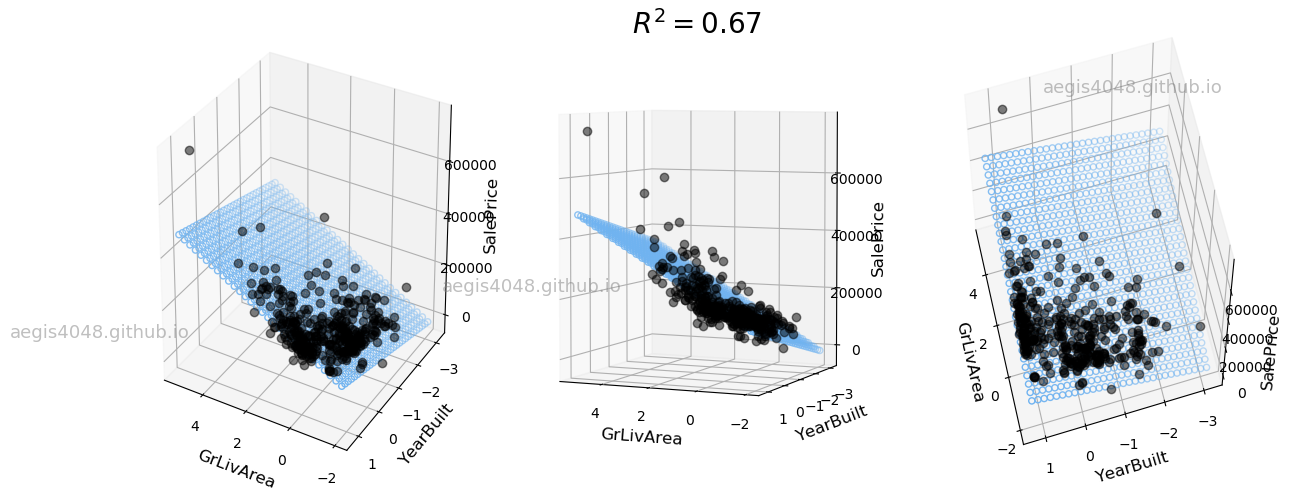

In [152]:
from mpl_toolkits.mplot3d.axes3d import get_test_data
predicted_viz = linear_reg.predict(model_viz)

plt.style.use('default')

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(X_test[:, 0], X_test[:, 1], y_test, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted_viz, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('GrLivArea', fontsize=12)
    ax.set_ylabel('YearBuilt', fontsize=12)
    ax.set_zlabel('SalePrice', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2_result, fontsize=20)

fig.tight_layout()

### SVM

In [174]:
from sklearn.svm import SVR
#Model
svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.1))

#学習
model_svr = svr.fit(X_train, y_train)

#推定
print(model_svr.predict(X_test))

[164844.89487193 165181.29359015 164836.20308932 164959.55265671
 165274.51186157 164885.97373372 165016.00226553 165075.67953889
 164879.99217169 164896.36153999 164882.49259121 164850.80955371
 164822.91081832 165248.67652029 165280.75704139 164807.87886155
 165292.38714408 164843.90387161 164861.88395634 165228.51629483
 165053.03630199 165267.73273052 165231.79595793 164812.4396376
 165198.38936832 165074.83552788 165188.05577203 164810.0606977
 165250.06769051 165190.31616083 164908.4691577  165299.80475546
 165070.87212485 164812.37843795 165277.62835409 164868.21818022
 165044.02197484 165307.05999595 165203.71643392 164814.41215625
 164822.20568616 165284.70142543 164868.56755042 165295.62536267
 164827.75678482 165030.10415902 164835.43911856 164845.17990398
 165250.95634678 164960.41620263 164803.54478906 165113.37077051
 164996.57680387 165114.34096813 165026.80858872 165295.10700024
 165274.98685929 164940.4979875  164931.04829421 164817.69909691
 164916.46551107 164867.232

In [192]:
#評価
MSE_svr = mean_squared_error(y_test, model_svr.predict(X_test))
MSE_svr

7169223057.829623

In [191]:
r2_svr = model_svr.score(X_test, y_test)
r2_svr

-0.023398540202243634

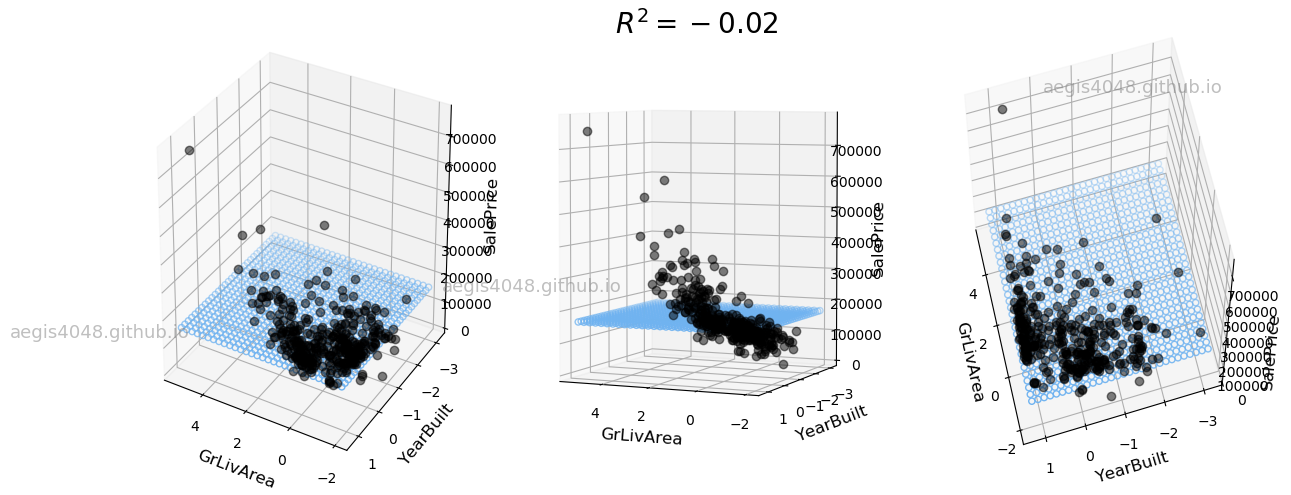

In [175]:
from mpl_toolkits.mplot3d.axes3d import get_test_data
predicted_viz = model_svr.predict(model_viz)

plt.style.use('default')

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(X_test[:, 0], X_test[:, 1], y_test, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted_viz, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('GrLivArea', fontsize=12)
    ax.set_ylabel('YearBuilt', fontsize=12)
    ax.set_zlabel('SalePrice', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2_svr, fontsize=20)

fig.tight_layout()

### 決定木


In [179]:
#決定木
from sklearn.tree import DecisionTreeRegressor

#Model
decision_tree = DecisionTreeRegressor(random_state=0)

#学習
model_decision_tree = decision_tree.fit(X_train, y_train)

#推定
print(model_decision_tree.predict(X_test))

[132000.         336000.          88000.         140000.
 256300.          81000.         220000.         148500.
  83000.          93000.         230000.         120500.
 119000.         259000.         173000.         137000.
 196500.         132500.         113000.         192000.
 257500.         287090.         169995.         112500.
 170000.         177500.         200141.          82000.
 236500.         194700.         116000.         244000.
 359100.         115000.         250000.         155000.
 137000.         198500.         260000.         106500.
 155000.         271000.         129000.         372500.
 178400.         122500.         147000.          94750.
 501837.         127000.         104100.         215000.
 181000.         272000.         144433.33333333 255500.
 231500.         160000.         148000.         105500.
  60000.         142000.         354000.         222000.
 226700.         226000.         108000.         239686.
 129200.         191000.       

In [197]:
MSE_decision_tree = mean_squared_error(y_test, model_decision_tree.predict(X_test))
MSE_decision_tree

2276521219.835921

In [198]:
r2_decision_tree = model_decision_tree.score(X_test, y_test)
r2_decision_tree

0.6750291524860406

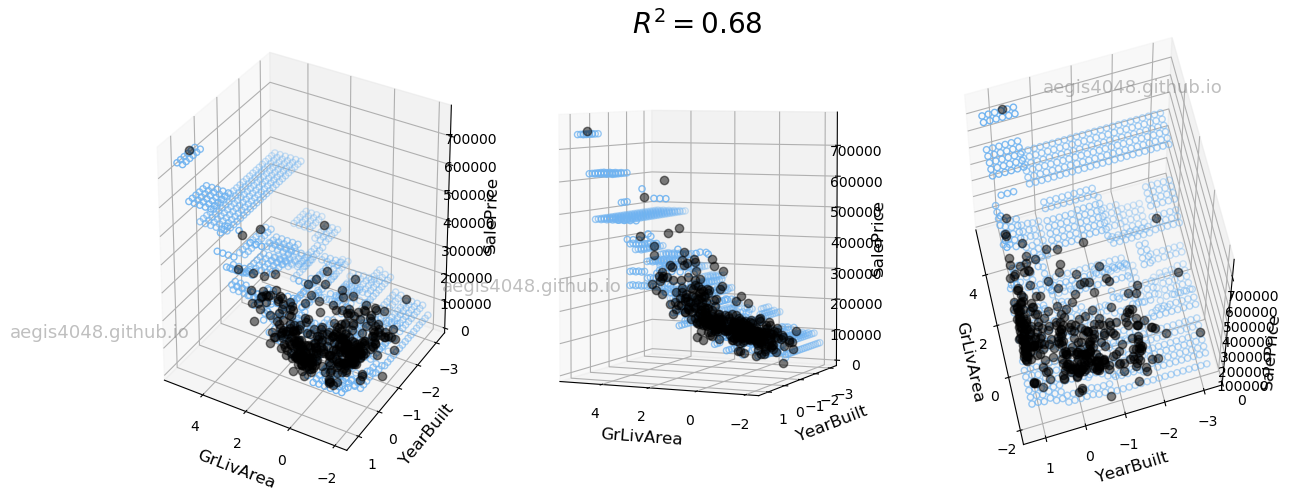

In [182]:
from mpl_toolkits.mplot3d.axes3d import get_test_data
predicted_viz = model_decision_tree.predict(model_viz)

plt.style.use('default')

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(X_test[:, 0], X_test[:, 1], y_test, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted_viz, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('GrLivArea', fontsize=12)
    ax.set_ylabel('YearBuilt', fontsize=12)
    ax.set_zlabel('SalePrice', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2_decision_tree, fontsize=20)

fig.tight_layout()

### ランダムフォレスト

In [183]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

#Model
random_forest = RandomForestRegressor(max_depth=2, random_state=0)

#学習
model_random_forest = random_forest.fit(X_train, y_train)

#推定
print(model_random_forest.predict(X_test))

[130087.55741264 295111.18922759 129333.57783549 160009.17127578
 219549.68138221 130087.55741264 197597.97935828 139674.60439845
 130087.55741264 130367.42543158 136756.56908734 130087.55741264
 129333.57783549 216515.82463659 221293.29209635 129333.57783549
 223973.88724668 130087.55741264 129333.57783549 199420.40000411
 181626.88946774 219549.68138221 199420.40000411 130087.55741264
 198599.98101776 194444.66344867 195029.92917217 129333.57783549
 219549.68138221 195029.92917217 129333.57783549 277446.16919422
 223366.75704915 130087.55741264 219549.68138221 130087.55741264
 193747.464686   254940.02073167 290880.87458798 130087.55741264
 129333.57783549 280521.95770101 130087.55741264 278716.54534882
 130087.55741264 199373.69922303 130087.55741264 130087.55741264
 286707.82745622 154259.10984656 129333.57783549 159377.43408829
 132300.737111   223366.75704915 195029.92917217 223973.88724668
 225049.4077571  132709.49191298 132300.737111   129333.57783549
 129333.57783549 130087.5

In [188]:
MSE_random_forest = mean_squared_error(y_test, model_random_forest.predict(X_test))
MSE_random_forest

2805721096.3882065

In [185]:
r2_random_forest = model_random_forest.score(X_test, y_test)
r2_random_forest

0.5994864644192568

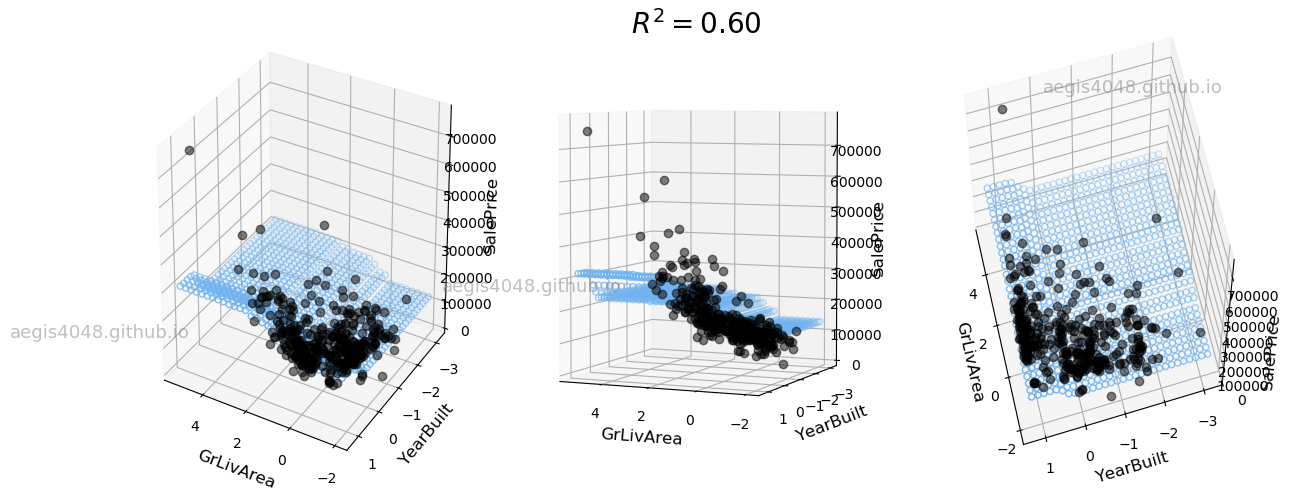

In [186]:
from mpl_toolkits.mplot3d.axes3d import get_test_data
predicted_viz = model_random_forest.predict(model_viz)

plt.style.use('default')

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(X_test[:, 0], X_test[:, 1], y_test, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted_viz, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('GrLivArea', fontsize=12)
    ax.set_ylabel('YearBuilt', fontsize=12)
    ax.set_zlabel('SalePrice', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='right', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2_random_forest, fontsize=20)

fig.tight_layout()

In [214]:
#指標値を１つの表にまとめてください

summary_stats = pd.DataFrame()
pd.set_option('display.float_format', lambda x: '%.5f' % x)
#pd.reset_option('display.float_format')

summary_stats['線形回帰'] = [MSE_linear_reg, r2_linear_reg]
summary_stats['SVM'] = [MSE_svr, r2_svr]
summary_stats['決定木'] = [MSE_decision_tree, r2_decision_tree]
summary_stats['ランダムフォレスト'] = [MSE_random_forest, r2_random_forest]

summary_stats.rename(index={0: 'MSE', 1: 'r2'})
summary_stats.round()
summary_stats

,線形回帰,SVM,決定木,ランダムフォレスト
0,2314465092.73201,7169223057.82962,2276521219.83592,2805721096.38821
1,0.66961,-0.02340,0.67503,0.59949


分析結果：
- いずれのモデルも性能はそれほど良くない。MSEの値も億単位とかなり外れている模様
- 一番性能が良かったのは、線形回帰であるが、そのほかの特徴量を付け加えて性能をあげる必要性がうかがえる
- 決定木・SVM・ランダムフォレストは非連続的な推定を行なっているように可視化された。特にSVMの結果はなぜ、これほどまで悪かったのか今後検討すべき。